# TP2 - Algoritmo de Boosting - Aprendizado de Máquina
## Nome: Alexandre Maros

PPGCC - UFMG - 2018/1

Este é o notebook referente ao segundo trabalho prático da disciplina de Aprendizado de Máquina da UFMG

O objetivo é implementar o algoritmo de Boosting, completamente do 0, sem a ajuda de bibliotecas externas e com Decision Stumps.

O dataset que deve ser utilizado é o do Tic-Tac-Toe e está disponivel em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame, o objetivo é identificar se o 'x' vai ganhar (positivo) ou não (negativo) dado uma instância do tabuleiro qualquer.

In [1]:
import os, time, math, random, itertools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10

In [2]:
data2 = pd.read_csv('data/tic-tac-toe.data', header=None)
data2

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [3]:
# Armazenar o label correto dos numeros
data = data2.rename(columns = {9:'label'})
# Trocar positivo por +1 e negativo por -1
data['label'] = data['label'].replace({'positive': 1, 'negative': -1})

# Separar label das features
y = data.label
X = data.drop("label", axis=1)

# Definição de Funções de Utilidade

Função __plot_loss_curve__: Simples função para _plottar_ as curvas de treino e teste para o ensemble e a curva de erro para o modelo fraco, variando a quantidade de modelos fracos utilizados

In [4]:
def plot_loss_curve(xs, ensemble_training_error, ensemble_test_error, model_err_train, title='Error Curve'):
    timestamp = str(time.time()).split('.')[0]
    fig = plt.figure(figsize=(11, 6), dpi= 80)
    plt.style.use('ggplot')
    plt.title(title)
    plt.ylabel('Error Rate')
    plt.xlabel('Number of Weak Learners')
    plt.plot(xs, ensemble_training_error, 'b-', label="Ensemble Training Error")
    plt.plot(xs, ensemble_test_error, 'r-', label="Ensemble Test Error")
    plt.plot(xs, model_err_train, 'm-', label="Weak Model Training Error")
    plt.legend(loc="best")
    plt.savefig('loss_curve_' + timestamp + '.pdf', format='pdf', bbox_inches='tight' )
    return plt

Função __k_fold__: Função para fazer a técnica de validação cruzada K-Fold

In [5]:
def k_fold(dataset, folds=5):
    indexes_split = []
    indexes = list(dataset.index)
    fold_size = int(dataset.shape[0] / folds)
    for i in range(folds):
        fold = []
        while len(fold) < fold_size:
            index = random.randrange(len(indexes))
            fold.append(indexes.pop(index))
        indexes_split.append(fold)
    return indexes_split

# Implementação do Decision Stump

...

In [6]:
class DecisionStump:
    def __init__(self):
        # Possiveis categorias que o dado vai ter para poder realizar as perguntas (Tem x na posição 0?)
        # No caso do tick-tack-toe vai ser x, o e b
        self.unique_categories = []
        # Dimensionalidade do dado, para saber quantas possíveis posições pode ter
        self.data_dimension = 0
        
        self.model = {
            'question_column' : None,
            'question_cat'    : None,
            'value'           : None,
            'train_weighted_error' : None,
            'train_accuracy'       : None
        }
        
    def fit(self, X, y, weights):
        """Seleciona o modelo com base em X, y e os pesos de cada entrada"""
        
        # Guarda todos os valores possiveis para todas as colunas e a dimensao dos dados
        # No caso do Tick-Tack-Toe, sera x,o,b para todas
        for column in X:
            self.unique_categories.append(X[column].unique())
        self.data_dimension = len(list(X))
        
        best_model_error = 1
        for i in range(0, self.data_dimension):
            for cat in self.unique_categories[0]:
                for value in (-1, 1):
                    error = self._compute_training_error(X, y, i, cat, value, weights=weights)
                    if (error[0] < best_model_error):
                        best_model_error  = error[0]
                        self.model['question_column'] = i
                        self.model['question_cat']    = cat
                        self.model['value']           = value
                        self.model['train_weighted_error'] = error[0]
                        self.model['train_acccuracy']      = error[1]
        return self
    
    def predict(self, X):
        """Prevê os valores das entradas em X"""
        if (self.model['question_column'] == None):
            print('Model was not fitted')
            return
        
        predictions = []
        for row in X:
            if( row[self.model['question_column']] == self.model['question_cat'] ):
                predictions.append(self.model['value'])
            else:
                predictions.append(-self.model['value'])
        return predictions
    
    def _compute_training_error(self, X, y, question_column, question_cat, value, weights=None):
        nb_samples  = X.count()[0]
        right_count = 0
        error = 0
        for i, row in X.iterrows():
            if( (row[question_column] == question_cat and y[i] == value) or 
                  (row[question_column] != question_cat and y[i] != value) ):
                right_count += 1
            else:
                error += weights[i]
        
        accuracy = right_count / float(nb_samples)
        
        # Error is weighted error, for actual error do 1-accuracy
        return (error, accuracy)
    
    def get_empirical_weighted_error(self):
        return self.model['train_weighted_error']
    
    def get_empirical_accuracy(self):
        return self.model['train_acccuracy']

# Implementação do algoritmo de Boosting

...

In [7]:
class AdaBoost:
    def __init__(self, nb_estimators = 30):
        self.nb_estimators = nb_estimators
        self.models  = []
        self.weights = []
        self.alphas  = []
        
        self.models_error_rate = []
        
    def fit(self, X, y):
        
        # Calculate initial weights
        weights = pd.Series(index=y.index.copy())
        weights[:] = 1.0 / y.shape[0]
        self.weights.append( weights )
        
        for i in range(0, self.nb_estimators):
            # Calculate new models
            dt = DecisionStump()
            dt.fit(X, y, self.weights[i])
            self.models.append(dt)
            self.models_error_rate.append(dt.get_empirical_weighted_error())
            
            # Calculate new alpha
            error = dt.get_empirical_weighted_error()
            alpha = 0.5 * math.log( (1 - error) / error )
            self.alphas.append(alpha)
            
            # Calculate new weights
            new_weights = pd.Series(index=y.index.copy())
            right_count = 0
            for index, _ in new_weights.iteritems():
                prediction = dt.predict(np.array([ X.loc[index].values ]))[0]
                true_y     = y[index]
                new_weights[index] = self.weights[i][index] * math.exp( -alpha * prediction * true_y )
                    
            new_weights = new_weights.apply(lambda x: float(x) / new_weights.sum())
            self.weights.append( new_weights )
        
        return self
    
    def _sign(self, value):
        if (value >= 0):
            return 1
        return -1
    
    def predict(self, X):
        """Prevê os valores das entradas em X"""
        if ( len(self.models) == 0 ):
            print('Model was not fitted')
            return
        
        predictions = []
        for row in X:
            sum_predictions = np.sum([ dt.predict([row])[0] * self.alphas[i] for i,dt in enumerate(self.models)])
            predictions.append( self._sign(sum_predictions))
        return predictions
    
    def compute_ensemble_error_rate(self, X, y):
        if ( len(self.models) == 0 ):
            print('Model was not fitted')
            return
        
        ensemble_error_rate = []
        for j in range(1, len(self.models)+1):
            right_count = 0
            for z, row in enumerate(X):
                sum_predictions = np.sum(
                    [ dt.predict([row])[0] * self.alphas[i] for i,dt in enumerate(self.models[0:j])])
                if (self._sign(sum_predictions) == y[z]):
                    right_count += 1
            accuracy = right_count / float(y.shape[0])
            ensemble_error_rate.append( 1-accuracy )
                
        return ensemble_error_rate
    
    def compute_test_error_rate(self, X, y):
        if ( len(self.models) == 0 ):
            print('Model was not fitted')
            return
        
        right_count = 0
        for z, row in enumerate(X):
            prediction = self.predict([row])[0]
            if (prediction == y[z]):
                right_count += 1
        accuracy = right_count / float( len(y) )
        return (1 - accuracy)

# Experimentos

Test 1/5:
	Fitting took 1166.4397685527802 seconds
Test 2/5:
	Fitting took 1167.1328287124634 seconds
Test 3/5:
	Fitting took 1176.1834371089935 seconds
Test 4/5:
	Fitting took 1148.3694818019867 seconds
Test 5/5:
	Fitting took 1134.5501947402954 seconds


<module 'matplotlib.pyplot' from '/data/alexandremaros/git/adaboost/venv-ada36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

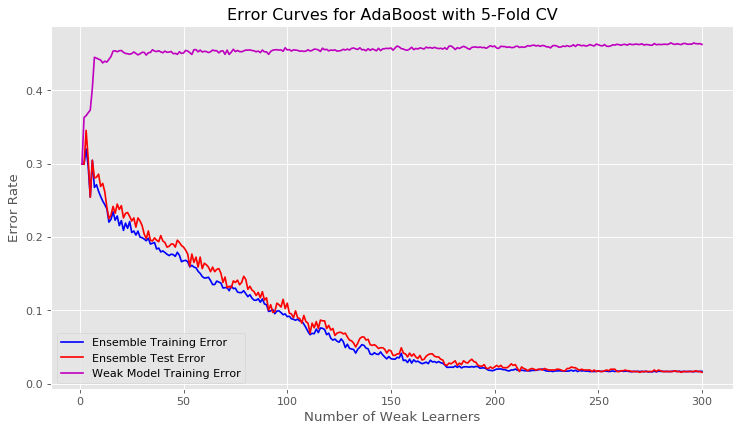

In [8]:
folds = 5
nb_estimators = 300
lst_ensemble_err_train = []
lst_ensemble_err_test  = []
lst_model_err_train    = []

indexes = k_fold(X, folds=folds)
for i, test_indexes in enumerate(indexes):
    print('Test {}/{}:'.format(i+1,folds))
    
    train_indexes = [ x for j,x in enumerate(indexes) if j != i ]
    train_indexes = list(itertools.chain.from_iterable(train_indexes))
    
    X_train = X.iloc[train_indexes]
    y_train = y.iloc[train_indexes]
    X_test  = X.iloc[test_indexes]
    y_test  = y.iloc[test_indexes]

    adb = AdaBoost(nb_estimators=nb_estimators)
    start = time.time()
    adb.fit(X_train, y_train)
    end   = time.time()
    print('\tFitting took {} seconds'.format(end-start))
    ensemble_err_train = adb.compute_ensemble_error_rate(X_train.values, y_train.values)
    enemble_err_test   = adb.compute_ensemble_error_rate(X_test.values, y_test.values)
    model_err_train    = adb.models_error_rate
    
    lst_ensemble_err_train.append(ensemble_err_train)
    lst_ensemble_err_test.append(enemble_err_test)
    lst_model_err_train.append(model_err_train)

plot_loss_curve([x for x in range(1,nb_estimators+1)],
                np.mean(lst_ensemble_err_train, axis=0),
                np.mean(lst_ensemble_err_test, axis=0),
                np.mean(lst_model_err_train, axis=0),
                title='Error Curves for AdaBoost with 5-Fold CV')

In [9]:
min_err = 2
nb_wk_learners = 0
for i, err in enumerate(np.mean(lst_ensemble_err_test, axis=0)):
    if (err < min_err):
        min_err = err
        nb_wk_learners = i+1
print('Best model found used {0:} estimators and model got accuracy of {1:.3f}%'.format(nb_wk_learners, (1-min_err)*100))

Best model found used 270 estimators and model got accuracy of 98.429%


In [10]:
folds = 5

adb50_test_error   = []
adb150_test_error  = []
adb250_test_error  = []
adb250_alphas      = []

indexes = k_fold(X, folds=folds)
for i, test_indexes in enumerate(indexes):
    print('Test {}/{}'.format(i+1,folds))
    
    train_indexes = [ x for j,x in enumerate(indexes) if j != i ]
    train_indexes = list(itertools.chain.from_iterable(train_indexes))
    
    X_train = X.iloc[train_indexes]
    y_train = y.iloc[train_indexes]
    X_test  = X.iloc[test_indexes]
    y_test  = y.iloc[test_indexes]
    
    adb50  = AdaBoost(nb_estimators=50)
    adb150 = AdaBoost(nb_estimators=150)
    adb250 = AdaBoost(nb_estimators=250)
    
    adb50.fit(X_train, y_train)
    adb150.fit(X_train, y_train)
    adb250.fit(X_train, y_train)
    
    adb250_alphas.append( adb250.alphas )
    
    adb50_test_error.append( adb50.compute_test_error_rate(X_test.values, y_test.values) )
    adb150_test_error.append( adb150.compute_test_error_rate(X_test.values, y_test.values) )
    adb250_test_error.append( adb250.compute_test_error_rate(X_test.values, y_test.values) )

Test 1/5
Test 2/5
Test 3/5
Test 4/5
Test 5/5


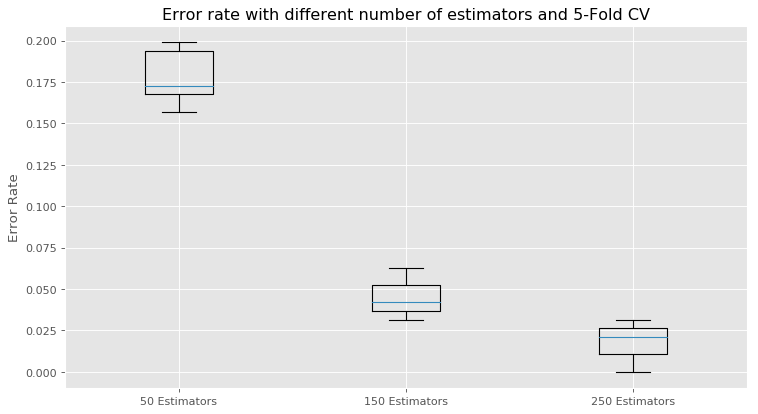

In [11]:
timestamp = str(time.time()).split('.')[0]
fig = plt.figure(figsize=(11, 6), dpi= 80)
plt.style.use('ggplot')
plt.title('Error rate with different number of estimators and 5-Fold CV')
plt.ylabel('Error Rate')
plt.boxplot( [adb50_test_error, adb150_test_error, adb250_test_error] )
plt.xticks([1,2,3], ['50 Estimators', '150 Estimators', '250 Estimators'] )
plt.savefig('boxplot_' + timestamp + '.pdf', format='pdf', bbox_inches='tight' )

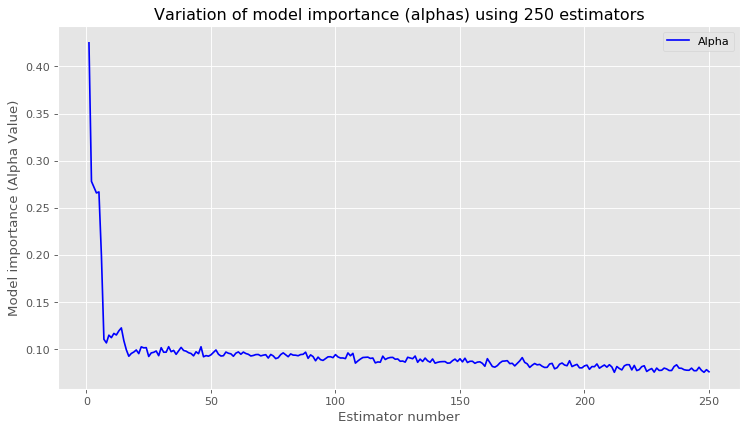

In [12]:
timestamp = str(time.time()).split('.')[0]
fig = plt.figure(figsize=(11, 6), dpi= 80)
plt.style.use('ggplot')
plt.title('Variation of model importance (alphas) using 250 estimators')
plt.ylabel('Model importance (Alpha Value)')
plt.xlabel('Estimator number')
plt.plot( [x for x in range(1,250+1)], np.mean(adb250_alphas, axis=0), 'b-', label='Alpha')
plt.legend(loc="best")
plt.savefig('alphas_' + timestamp + '.pdf', format='pdf', bbox_inches='tight' )

# Conclusões